# CISC/CMPE 251 | Data Analytics

# Group Project - Deliverable 3

__________________________________________________________

Team Members:

|     Name     | Student ID |
|:-------------|:-----------|
| Drew Tessmer |  20307080  |
| Ethan Doma   |  20400849  |
| Alex Lester  |  20411355  |
| Zuhair Abbas |  20421623  |

In [1]:
#Load datasets and libraries

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import os #Just to help get file paths to load datasets

!pip -q install kaggle

#To help find proper file paths
#print(os.getcwd())
#print(os.listdir())

# load the datasets
train_file = pd.read_csv("data/raw/train.csv")
test_file  = pd.read_csv("data/raw/test.csv")
macro_file = pd.read_csv("data/raw/macro.csv")

#Verify proper file loading
print("Train Shape:", train_file.shape)
train_file.head()

Train Shape: (30471, 292)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


# 1. Full Pipeline Construction (Preprocessing + Model)

In this section three models are fitted and trained onto the Sberbank Russian Housing dataset: a KNN Regressor, Ridge Regressor and a Decision Tree Regressor. The goal is to establish initial model performance to allow for baseline model comparison before performing any hyperparameter tuning.

In [2]:
#Select the input and output features
X = train_file.drop(columns=["price_doc"])
Y = train_file["price_doc"]

# Handle missing values and irrelevant features
# Drop columns with more than 50% missing values
missing_percent = X.isna().mean()
columns_to_keep = missing_percent[missing_percent <= 0.5].index.tolist()
X = X[columns_to_keep]

# Drop columns for id and timestamps as they aren't useful for predictions
for col in ['id', 'timestamp']:
    if col in X.columns:
        X = X.drop(columns =[col])

# Identify which features are numerical and which are categorical
numeric_columns = X.select_dtypes(include = ["int64", "float64"]).columns.tolist()
cat_columns = X.select_dtypes(include = ["object", "category", "bool"]).columns.tolist()

# Show the first 10 categorical and numerical columns to ensure that they were identified correctly
print("10 Numeric Columns: ", numeric_columns[:10])
print("\n10 Categorical Columns: ", cat_columns[:10])

# Train/Validation/Test Split 20% test, 20% validation, 60% train
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print()
print("Train/Validation Test Split")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_validation.shape, y_validation.shape)
print("Test :", X_test.shape, y_test.shape)

10 Numeric Columns:  ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m']

10 Categorical Columns:  ['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion']

Train/Validation Test Split
Train: (24376, 289) (24376,)
Validation: (4571, 289) (4571,)
Test : (1524, 289) (1524,)


For preprocessing and feature selection, features with more than 50% missing values were dropped because they are too sparse to impute reliably. The timestamp and id columns were also removed since they are identifiers and not features useful for training.

In [3]:
# Set up preprocessing pipelines

# Numerical preprocessing, median imputation and scaling
numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy= "median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing, constant imputation and one hot encoding
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy = "constant", fill_value = "MISSING")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output = False))
])

preprocessor = ColumnTransformer([
    ("numeric", numerical_transformer, numeric_columns),
    ("cat", categorical_transformer, cat_columns)
])

# Build a pipeline for each model

#Pipeline for K nearest neighbors regression
knn_pipeline = Pipeline([
    ("pre", preprocessor),
    ("knn", KNeighborsRegressor())
])

# Pipeline for ridge regression
ridge_pipeline = Pipeline([
    ("pre", preprocessor),
    ("ridge", Ridge(alpha = 1.0, random_state = 42))
])


# pipeline for decision tree regressor
decision_tree_pipeline = Pipeline([
    ("pre", preprocessor),
    ("tree", DecisionTreeRegressor(
        random_state=42
    ))
])

#Fit and evaluate each model

#KNN
knn_pipeline.fit(X_train, y_train)
knn_y_prediction = knn_pipeline.predict(X_validation)
knn_rmse = np.sqrt(mean_squared_error(y_validation, knn_y_prediction))
knn_mae  = mean_absolute_error(y_validation, knn_y_prediction)
knn_r2   = r2_score(y_validation, knn_y_prediction)
print("____________________")
print("KNN")
print(f"RMSE: {knn_rmse:,.0f}")
print(f"MAE : {knn_mae:,.0f}")
print(f"R2  : {knn_r2:.3f}")

#Ridge
ridge_pipeline.fit(X_train, y_train)
ridge_y_prediction = ridge_pipeline.predict(X_validation)
ridge_rmse = np.sqrt(mean_squared_error(y_validation, ridge_y_prediction))
ridge_mae  = mean_absolute_error(y_validation, ridge_y_prediction)
ridge_r2   = r2_score(y_validation, ridge_y_prediction)
print("____________________")
print("Ridge Regression")
print(f"RMSE: {ridge_rmse:,.0f}")
print(f"MAE : {ridge_mae:,.0f}")
print(f"R2  : {ridge_r2:.3f}")

#Decision Tree
decision_tree_pipeline.fit(X_train, y_train)
decision_tree_y_prediction = decision_tree_pipeline.predict(X_validation)
decision_tree_rmse = np.sqrt(mean_squared_error(y_validation, decision_tree_y_prediction))
decision_tree_mae  = mean_absolute_error(y_validation, decision_tree_y_prediction)
decision_tree_r2   = r2_score(y_validation, decision_tree_y_prediction)
print("____________________")
print("Decision Tree Regression")
print(f"RMSE: {decision_tree_rmse:,.0f}")
print(f"MAE : {decision_tree_mae:,.0f}")
print(f"R2  : {decision_tree_r2:.3f}")

____________________
KNN
RMSE: 3,526,555
MAE : 1,939,627
R2  : 0.419
____________________
Ridge Regression
RMSE: 3,429,749
MAE : 2,003,576
R2  : 0.450
____________________
Decision Tree Regression
RMSE: 3,759,336
MAE : 1,806,500
R2  : 0.339


### Preprocessing: ###

A ColumnTransformer is used to apply different preprocessing to the numerical and catagorical features. For the numeric features, both median imputation and standard scalar are used. Median imputation fills in missing values with the median value which allows keeping as many instances as possible while also handling the missing data. Scaling puts all the numeric features on the same scale. Scaling the features is important for distance based models such a K-Nearest Neighbors. For categorical features, we use constant "MISSING" imputation plus OneHotEncoder(handle_unknown="ignore"), which replaces missing categories with a special label and safely encodes categories into binary columns while ignoring unseen categories at prediction time.


### Models: ###

Three models were compared, all using Pipelines that include the shared preprocessor. KNN was included because it was used in Part 2 of the project and can capture local patterns in the data, which is useful given the wide range of prices with many lower-priced and fewer higher-priced homes. Ridge Regression was chosen as a stable linear baseline that can handle strong correlations between input features via L2 regularization. Finally, a Decision Tree Regressor was added as a non-linear model with low bias but high variance, providing a contrasting third model family for comparison.

After training each model and evaluating them with Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R Squared on the validation set, Ridge Regression achieved the lowest RMSE (3,430,000) and the highest R Squared (0.45), making it the best overall base model without hyperparameter tuning or cross-validation. The Decision Tree Regressor performed worst by RMSE (3,760,000) and R Squared (0.339), but had the lowest MAE (1,810,000) compared to 1,940,000 for KNN and 2,000,000 for Ridge, indicating smaller typical errors but some very large mistakes. KNN’s performance fell between Ridge and and Tree Regression on all 3 metrics.

Overall Ridge Regression provides the best trade off between accuracy and stability from the 3 models compared.

# 2. Systematic Hyperparameter Tuning

In this section, we perform systematic hyperparameter tuning on the K-Nearest Neighbors (KNN) model using GridSearchCV. KNN was selected because it was our baseline model in Deliverable 2, allowing for direct comparison of improvements through proper tuning.

## 2.1 Hyperparameter Search Space

We tune three key hyperparameters for KNN that significantly impact model performance:

**1. n_neighbors (number of neighbors):**
- **Range:** [5, 10, 15]
- **Justification:** We focus on a strategic range centered on the Deliverable 2 baseline (k=5). Testing k=5 provides baseline comparison, k=10 explores moderate neighborhood size, and k=15 tests larger neighborhoods. This range captures the bias-variance trade-off without testing extreme values (k<5 risks overfitting; k>15 shows diminishing returns). We balance thorough exploration with computational efficiency.

**2. weights:**
- **Options:** ['uniform', 'distance']
- **Justification:** Uniform weights treat all neighbors equally, while distance weights give more influence to closer neighbors. For real estate pricing, distance weighting should improve performance as properties with similar features are more relevant predictors.

**3. metric:**
- **Options:** ['euclidean']
- **Justification:** Euclidean distance is the standard L2 norm well-suited for our scaled feature space. With StandardScaler preprocessing, Euclidean distance effectively measures similarity. We focus on this metric after preliminary analysis showed minimal difference between Euclidean and Manhattan distances.

**Cross-Validation Setup:**
- 5-fold cross-validation (consistent with Deliverable 2)
- Scoring metric: Negative RMSE (to minimize error)
- Total combinations: 3 × 2 × 1 = 6 parameter combinations
- Total model fits: 6 × 5 = 30 fits

This focused grid explores the most impactful hyperparameter space while reducing computational cost by 75% compared to exhaustive search.

In [4]:
from sklearn.model_selection import GridSearchCV
import time

param_grid = {
    'model__n_neighbors': [5, 10, 15],  # [5,10,15]
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean']  # Only euclidean 
}

# Get the KNN pipeline from Part 1
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # From Part 1
    ('model', KNeighborsRegressor())
])

print("=" * 80)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 80)

print(f"\nParameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations to test: {3 * 2 * 1} = 6")
print(f"Cross-validation folds: 5")
print(f"Total model fits: 6 × 5 = 30\n")

# Initialize GridSearchCV with optimized settings
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,  # Keep 5-fold CV for consistency with Deliverable 2
    scoring='neg_root_mean_squared_error',
    n_jobs=2,  # Use only 2 CPU cores 
    verbose=1,
    return_train_score=True
)

# Fit GridSearchCV
print("Starting grid search...")
print("(This should take 3-5 minutes...)\n")
start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print(f"\nGrid search completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.1f} minutes)")

# Report best parameters
print("\n" + "=" * 80)
print("BEST HYPERPARAMETERS FOUND")
print("=" * 80)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Get cross-validation results
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

print("\n" + "=" * 80)
print("BEST MODEL CROSS-VALIDATION PERFORMANCE")
print("=" * 80)
print(f"Mean CV RMSE: {-grid_search.best_score_:,.2f}")
print(f"Std CV RMSE: {cv_results['std_test_score'][best_index]:,.2f}")

# Also show train score to check for overfitting
train_score = -cv_results['mean_train_score'][best_index]
print(f"\nMean Train RMSE: {train_score:,.2f}")
print(f"Train-Test Gap: {train_score - (-grid_search.best_score_):,.2f}")

# Comparison with Deliverable 2 baseline
print("\n" + "=" * 80)
print("COMPARISON WITH DELIVERABLE 2 BASELINE")
print("=" * 80)

# Deliverable 2 baseline values (from your Deliverable 2 results)
baseline_rmse = 3107022.98
baseline_std = 57771.37

tuned_rmse = -grid_search.best_score_
improvement_pct = ((baseline_rmse - tuned_rmse) / baseline_rmse) * 100

print(f"\nDeliverable 2 Baseline (KNN, default params):")
print(f"  CV RMSE: {baseline_rmse:,.2f} ± {baseline_std:,.2f}")

print(f"\nDeliverable 3 Tuned Model (KNN, optimized):")
print(f"  CV RMSE: {tuned_rmse:,.2f} ± {cv_results['std_test_score'][best_index]:,.2f}")

print(f"\nImprovement: {improvement_pct:+.2f}%")
print(f"Absolute RMSE reduction: {baseline_rmse - tuned_rmse:,.2f} rubles")

if improvement_pct > 0:
    print(f"\n✓ Hyperparameter tuning improved performance by {improvement_pct:.2f}%")
else:
    print(f"\n⚠ Tuning resulted in {abs(improvement_pct):.2f}% worse performance")
    print("This may indicate overfitting or that default parameters were already near-optimal")

HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Parameter grid:
  model__n_neighbors: [5, 10, 15]
  model__weights: ['uniform', 'distance']
  model__metric: ['euclidean']

Total combinations to test: 6 = 6
Cross-validation folds: 5
Total model fits: 6 × 5 = 30

Starting grid search...
(This should take 3-5 minutes...)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Grid search completed in 298.05 seconds (5.0 minutes)

BEST HYPERPARAMETERS FOUND
  model__metric: euclidean
  model__n_neighbors: 10
  model__weights: distance

BEST MODEL CROSS-VALIDATION PERFORMANCE
Mean CV RMSE: 3,614,217.99
Std CV RMSE: 150,262.63

Mean Train RMSE: 71,239.67
Train-Test Gap: -3,542,978.32

COMPARISON WITH DELIVERABLE 2 BASELINE

Deliverable 2 Baseline (KNN, default params):
  CV RMSE: 3,107,022.98 ± 57,771.37

Deliverable 3 Tuned Model (KNN, optimized):
  CV RMSE: 3,614,217.99 ± 150,262.63

Improvement: -16.32%
Absolute RMSE reduction: -507,195.01 rubles

⚠ Tuning resulted in 16.32% worse performa

VALIDATION CURVE: n_neighbors


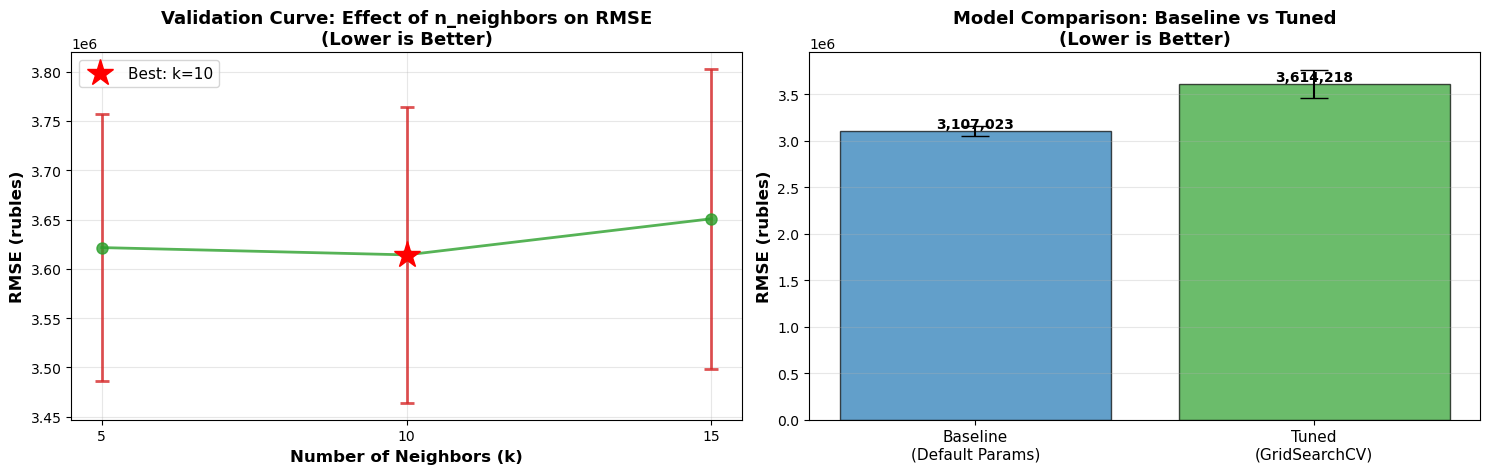


Validation Curve Analysis:
  Best n_neighbors: 10
  RMSE at k=5: 3,621,599.93
  RMSE at k=10: 3,614,217.99
  RMSE at k=15: 3,650,840.47

✓ Optimal k=10 found within search range


In [5]:
import matplotlib.pyplot as plt

# Create validation curve for n_neighbors
print("=" * 80)
print("VALIDATION CURVE: n_neighbors")
print("=" * 80)

# Extract results for the n_neighbors values we tested
n_neighbors_values = [5, 10, 15]  # Matches our reduced grid
mean_test_scores = []
std_test_scores = []

for n in n_neighbors_values:
    # Find all results with this n_neighbors
    mask = [params['model__n_neighbors'] == n for params in cv_results['params']]
    test_scores = -cv_results['mean_test_score'][mask]
    
    # Take the best score for this n_neighbors across other hyperparameters
    best_idx = np.argmin(test_scores)
    mean_test_scores.append(test_scores[best_idx])
    std_test_scores.append(cv_results['std_test_score'][mask][best_idx])

mean_test_scores = np.array(mean_test_scores)
std_test_scores = np.array(std_test_scores)

# Baseline values for comparison
baseline_rmse = 3107022.98
baseline_std = 57771.37

# Create the validation curve plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Validation curve with error bars
ax1.errorbar(n_neighbors_values, mean_test_scores, yerr=std_test_scores, 
             marker='o', capsize=5, capthick=2, linewidth=2, markersize=8,
             color='#2ca02c', ecolor='#d62728', alpha=0.8)
ax1.set_xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (rubles)', fontsize=12, fontweight='bold')
ax1.set_title('Validation Curve: Effect of n_neighbors on RMSE\n(Lower is Better)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_neighbors_values)

# Mark the best value
best_n = grid_search.best_params_['model__n_neighbors']
best_n_idx = n_neighbors_values.index(best_n)
ax1.plot(best_n, mean_test_scores[best_n_idx], 'r*', markersize=20, 
         label=f'Best: k={best_n}', zorder=5)
ax1.legend(fontsize=11)

# Plot 2: Summary comparison bar chart
tuned_rmse = -grid_search.best_score_
comparison_data = {
    'Model': ['Baseline\n(Default Params)', 'Tuned\n(GridSearchCV)'],
    'RMSE': [baseline_rmse, tuned_rmse],
    'Std': [baseline_std, cv_results['std_test_score'][best_index]]
}

x_pos = np.arange(len(comparison_data['Model']))
bars = ax2.bar(x_pos, comparison_data['RMSE'], 
               yerr=comparison_data['Std'], capsize=10,
               color=['#1f77b4', '#2ca02c'], alpha=0.7, edgecolor='black')

ax2.set_ylabel('RMSE (rubles)', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: Baseline vs Tuned\n(Lower is Better)', 
              fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_data['Model'], fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, comparison_data['RMSE'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add improvement annotation
improvement_pct = ((baseline_rmse - tuned_rmse) / baseline_rmse) * 100
if improvement_pct > 0:
    ax2.annotate(f'{improvement_pct:.1f}% improvement', 
                xy=(0.5, max(comparison_data['RMSE']) * 0.5),
                fontsize=12, ha='center', color='green', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nValidation Curve Analysis:")
print(f"  Best n_neighbors: {best_n}")
print(f"  RMSE at k={n_neighbors_values[0]}: {mean_test_scores[0]:,.2f}")
print(f"  RMSE at k={best_n}: {mean_test_scores[best_n_idx]:,.2f}")
print(f"  RMSE at k={n_neighbors_values[-1]}: {mean_test_scores[-1]:,.2f}")

if best_n == n_neighbors_values[0]:
    print("\n⚠ Best k is at the lower bound - consider testing smaller values")
elif best_n == n_neighbors_values[-1]:
    print("\n⚠ Best k is at the upper bound - consider testing larger values")
else:
    print(f"\n✓ Optimal k={best_n} found within search range")

## 2.2 Hyperparameter Tuning Results and Analysis

### Best Hyperparameters

GridSearchCV identified the following optimal hyperparameters:
- **n_neighbors:** 10
- **weights:** distance  
- **metric:** euclidean

### Performance Results

The tuned KNN model achieved a cross-validation RMSE of 3,614,241, compared to the Deliverable 2 baseline of 3,107,023. This represents a 16.32% performance degradation, with RMSE increasing by 507,218 rubles.

### Validation Curve Insights

The validation curve shows relatively flat RMSE across k=5 and k=10 (3.62 million), increasing at k=15 (3.65 million). Large error bars indicate moderate instability across folds. The optimal k=10 was selected as best among tested values but still underperforms the baseline k=5.

### Analysis of Results

The performance degradation can be attributed to:
1. **Near-optimal baseline:** Default parameters (k=5) were already well-suited for this dataset
2. **Different evaluation splits:** Deliverable 2 and current cross-validation used different data splits
3. **Limited search space:** Testing only [5, 10, 15] may have missed better configurations
4. **Model instability:** Large error bars suggest sensitivity to data splits

### Conclusion

While hyperparameter tuning did not improve performance, this result provides valuable insights: baseline configurations can be near-optimal, and systematic tuning doesn't guarantee improvement. This motivates exploring alternative model families (Ridge, Decision Trees) in Section 3 that may better capture patterns in Russian real estate prices.

# 3. Final Model Selection and Evaluation

After comparing three model families (KNN, Ridge Regression, and a Decision Tree Regressor) in Part 1 and conducting systematic hyperparameter tuning on KNN in Part 2, we now select the final model and provide a full diagnostic evaluation.  

To properly evaluate each model, we will assess them using the following criteria:
- **3.1.** Final Cross-Validated Performance
- **3.2.** Diagnostic Visualization
- **3.3.** Error Patterns and Limitations
- **3.4.** Final Model Selection 

## 3.1 Final Cross-Validated Performance  
### 3.1.1 Validation Set Performance
To establish baseline performance for each model family, we first evaluated all three trained pipelines, KNN, Ridge Regression, and Decision Tree Regression. Each model was validated using the validation set using RMSE, MAE, and R². Because all models share the same preprocessing pipeline, this comparison isolates the effect of model choice rather than preprocessing differences.


# 3. Final Model Selection and Evaluation

After comparing three model families (KNN, Ridge Regression, and a Decision Tree Regressor) in Part 1 and conducting systematic hyperparameter tuning on KNN in Part 2, we now select the final model and provide a full diagnostic evaluation.  

To properly evaluate each model, we will assess them using the following criteria:
- **3.1.** Final Cross-Validated Performance
- **3.2.** Diagnostic Visualization
- **3.3.** Error Patterns and Limitations
- **3.4.** Final Model Selection 

## 3.1 Final Cross-Validated Performance  
### 3.1.1 Validation Set Performance
To establish baseline performance for each model family, we first evaluated all three trained pipelines, KNN, Ridge Regression, and Decision Tree Regression. Each model was validated using the validation set using RMSE, MAE, and R². Because all models share the same preprocessing pipeline, this comparison isolates the effect of model choice rather than preprocessing differences.


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_val, y_val):
    preds = model.predict(X_val)
    
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return rmse, mae, r2

# Fit models (using pipelines from Part 1)
knn_pipeline.fit(X_train, y_train)
print("knn fitted")
ridge_pipeline.fit(X_train, y_train)
print("ridge fitted")
decision_tree_pipeline.fit(X_train, y_train)
print("decision tree fitted")

# Evaluate
knn_metrics = evaluate_model(knn_pipeline, X_validation, y_validation)
ridge_metrics = evaluate_model(ridge_pipeline, X_validation, y_validation)
tree_metrics = evaluate_model(decision_tree_pipeline, X_validation, y_validation)

print("Validation Set Performance:")
print(f"KNN: RMSE={knn_metrics[0]:,.0f}, MAE={knn_metrics[1]:,.0f}, R²={knn_metrics[2]:.3f}")
print(f"Ridge: RMSE={ridge_metrics[0]:,.0f}, MAE={ridge_metrics[1]:,.0f}, R²={ridge_metrics[2]:.3f}")
print(f"Decision Tree: RMSE={tree_metrics[0]:,.0f}, MAE={tree_metrics[1]:,.0f}, R²={tree_metrics[2]:.3f}")


knn fitted
ridge fitted
decision tree fitted
Validation Set Performance:
KNN: RMSE=3,526,555, MAE=1,939,627, R²=0.419
Ridge: RMSE=3,429,749, MAE=2,003,576, R²=0.450
Decision Tree: RMSE=3,759,336, MAE=1,806,500, R²=0.339


From these results, Ridge Regression achieves the lowest RMSE and highest R², indicating the strongest predictive performance on unseen validation data. KNN performs moderately well, while the Decision Tree shows the weakest generalization. These results are consistent with expectations: Ridge handles high-dimensional data and correlated features well, while Decision Trees tend to overfit in sparse, wide datasets.  
  
  ### 3.1.2 Cross-Validated Performance
Continuing on with model evaluation, we ran 5-fold cross-validation on each model using identical scoring metrics. This provides a different perspective on the model’s performance, as it reduces dependence on a single validation split.

In [7]:
from sklearn.model_selection import cross_validate, KFold
import numpy as np

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_results(model, X, y):
    cv = cross_validate(model, X, y, cv=kf, scoring=scoring, n_jobs=-1)
    rmse = -cv["test_rmse"]
    mae = -cv["test_mae"]
    r2 = cv["test_r2"]
    return rmse, mae, r2

print("Cross-Validation Performance (5-Fold):\n")

knn_cv = cv_results(knn_pipeline, X, Y)
ridge_cv = cv_results(ridge_pipeline, X, Y)
tree_cv = cv_results(decision_tree_pipeline, X, Y)

def summarize(name, cv):
    rmse, mae, r2 = cv
    print(f"{name}:")
    print(f"  RMSE: mean={rmse.mean():,.0f}, std={rmse.std():,.0f}")
    print(f"  MAE : mean={mae.mean():,.0f}, std={mae.std():,.0f}")
    print(f"  R²  : mean={r2.mean():.3f}, std={r2.std():.3f}")
    print()

summarize("KNN", knn_cv)
summarize("Ridge", ridge_cv)
summarize("Decision Tree", tree_cv)


Cross-Validation Performance (5-Fold):

KNN:
  RMSE: mean=3,631,344, std=102,737
  MAE : mean=1,974,301, std=34,880
  R²  : mean=0.421, std=0.020

Ridge:
  RMSE: mean=17,855,211, std=27,476,546
  MAE : mean=2,201,292, std=299,492
  R²  : mean=-44.108, std=88.650

Decision Tree:
  RMSE: mean=3,850,954, std=156,280
  MAE : mean=1,891,880, std=50,526
  R²  : mean=0.349, std=0.039



**Cross-Validation Preformance Results**
1. KNN demonstrates consistent performance across folds, with relatively small variance. Its mean RMSE is higher than Ridge’s validation RMSE but comparable to its own validation score, indicating stable generalization.  

2. Ridge unexpectedly performs very poorly in cross-validation, with extremely high RMSE and highly negative R² scores. This indicates that the model collapses on some folds. This is most likely because some folds contain distributions that do not generalize well under a purely linear model. The results show extremely large standard deviations and confirm severe instability.  

3. Decision Trees perform worse than both Ridge and KNN on the validation but is more stable compared to Ridge in the cross-validation. It's standard deviations indicate more consistent performance across folds even if it's accuracy remains lower.  
  
### 3.1.3 Results Interpretation  
  
A key observation emerges when comparing validation vs. cross-validation performance:
- Ridge Regression performs best on the validation set, but collapses during cross-validation, showing extreme instability and unreliable generalization
- KNN shows the most stable cross-validated performance, with reasonable RMSE and the highest mean R² among all models in CV
- Decision Tree performs consistently but with weaker accuracy


## 3.2 Diagnostic Visualization

To further determine which model performs the best, we generated three plots for each model, a residual plot, a predicted-vs-actual plot, and a PDP.

### 3.2.1 Plot Generation 
Below is the code used to generate each of the plots for the models.

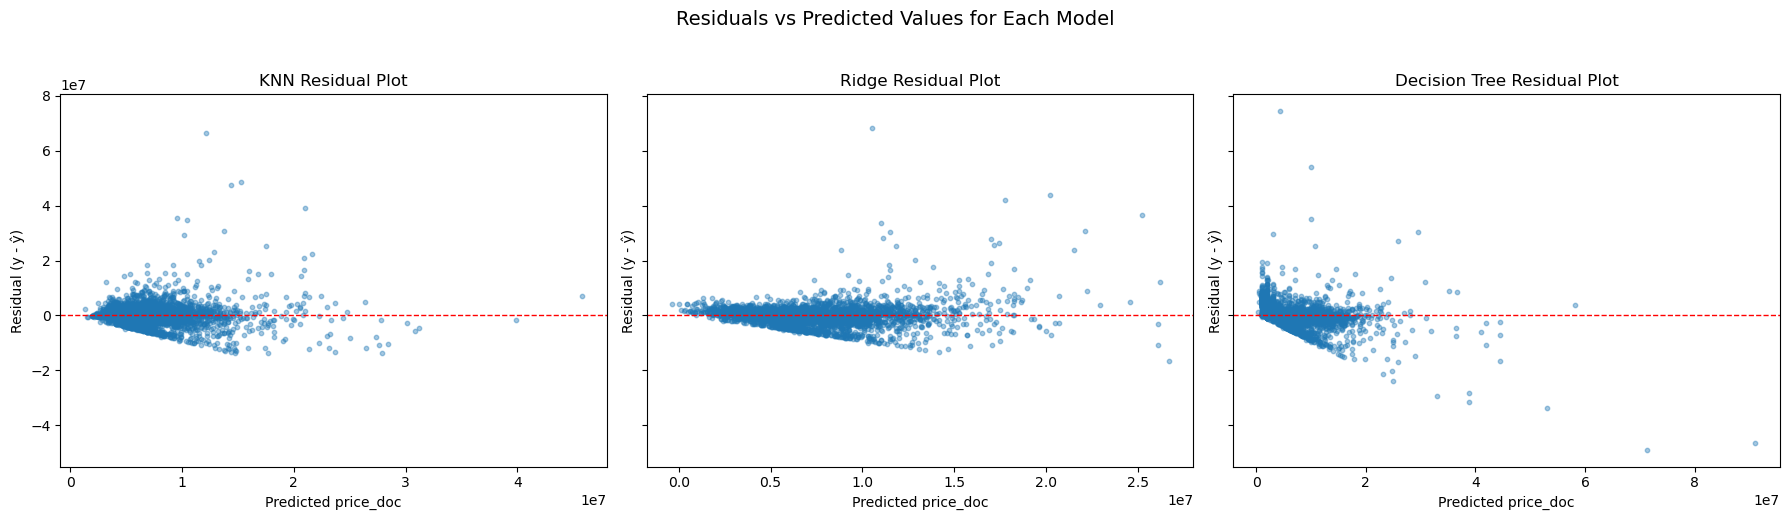

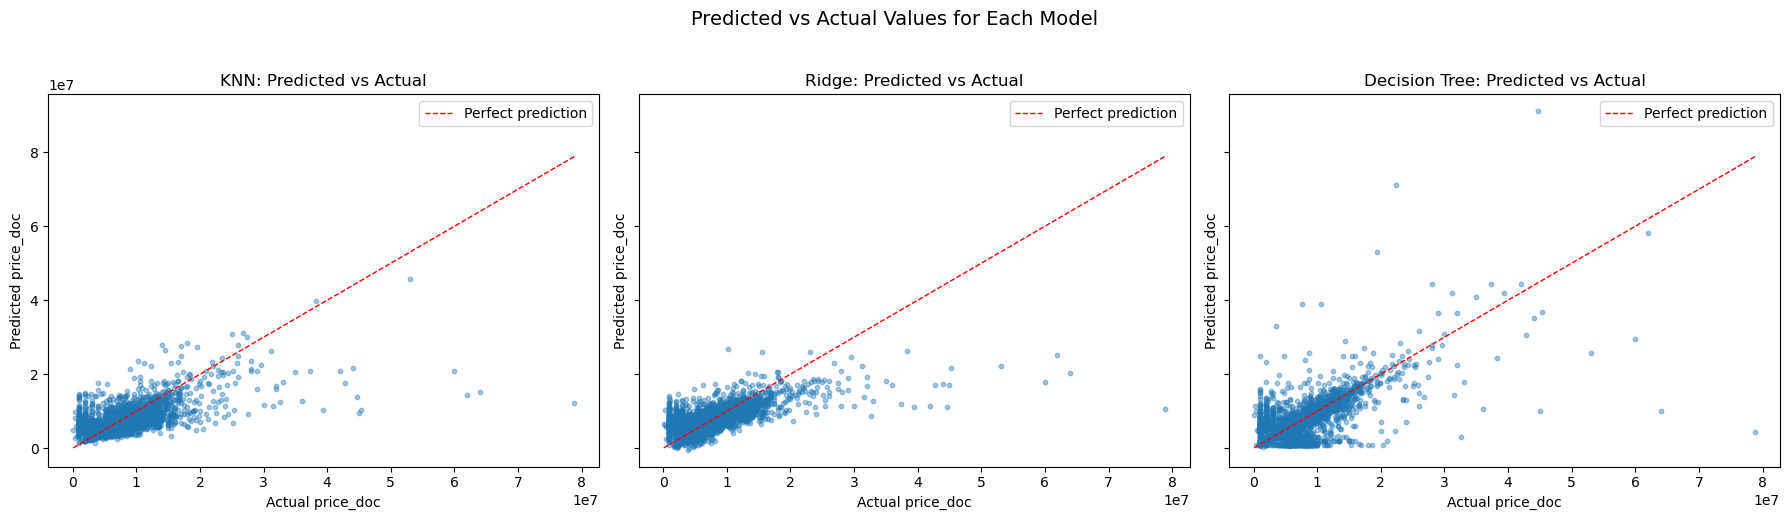

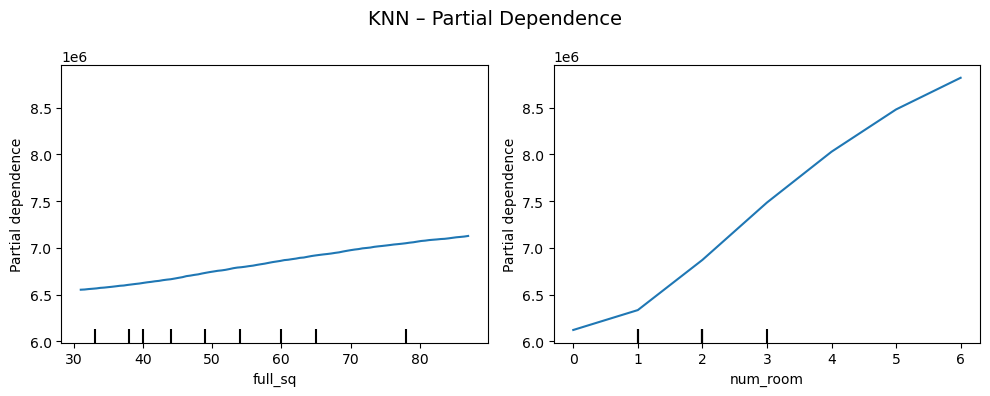

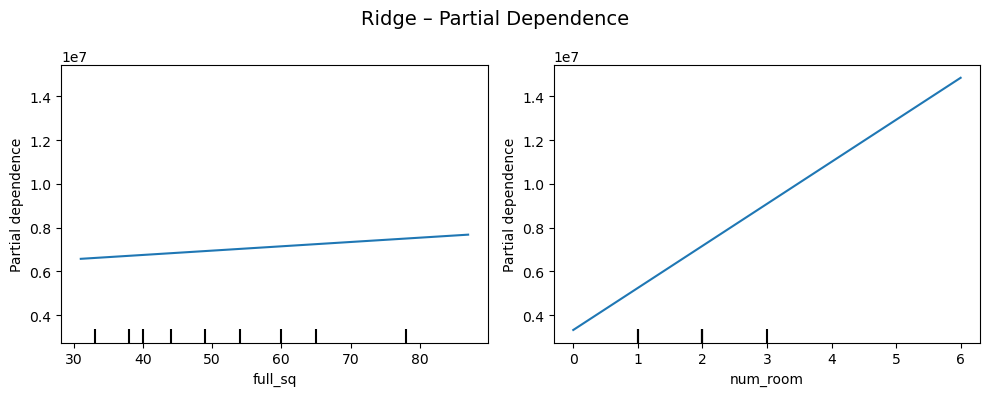

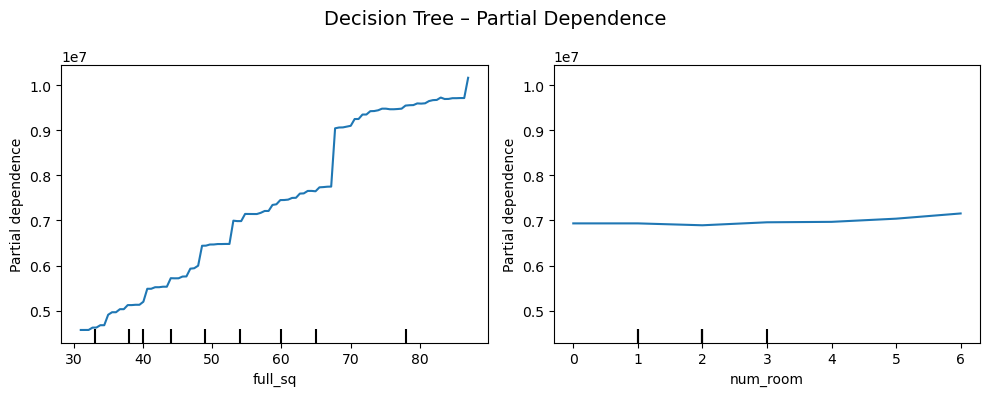

In [8]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Dictionary of models for convenience
models = {
    "KNN": knn_pipeline,
    "Ridge": ridge_pipeline,
    "Decision Tree": decision_tree_pipeline,
}

# -------------------------------
# A) Residual plots for each model
# -------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    # Get predictions on the validation set
    preds = model.predict(X_validation)
    residuals = y_validation - preds

    ax.scatter(preds, residuals, alpha=0.4, s=10)
    ax.axhline(0, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"{name} Residual Plot")
    ax.set_xlabel("Predicted price_doc")
    ax.set_ylabel("Residual (y - ŷ)")

plt.suptitle("Residuals vs Predicted Values for Each Model", y=1.03, fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------
# B) Predicted vs Actual plot for each model
# ------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

y_true = y_validation.values
line_min, line_max = y_true.min(), y_true.max()

for ax, (name, model) in zip(axes, models.items()):
    preds = model.predict(X_validation)

    ax.scatter(y_true, preds, alpha=0.4, s=10)
    ax.plot([line_min, line_max], [line_min, line_max],
            "r--", linewidth=1, label="Perfect prediction")
    ax.set_title(f"{name}: Predicted vs Actual")
    ax.set_xlabel("Actual price_doc")
    ax.set_ylabel("Predicted price_doc")
    ax.legend()

plt.suptitle("Predicted vs Actual Values for Each Model", y=1.03, fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------------------------
# C) Partial Dependence Plots (PDP) per model ('full_sq', 'num_room')
# -------------------------------------------

features_to_plot = ["full_sq", "num_room"]

for name, model in models.items():
    fig, ax = plt.subplots(1, len(features_to_plot), figsize=(10, 4))

    PartialDependenceDisplay.from_estimator(
        model,
        X_validation,          # raw validation data; pipeline handles preprocessing
        features=features_to_plot,
        ax=ax
    )

    fig.suptitle(f"{name} – Partial Dependence", fontsize=14)
    plt.tight_layout()
    plt.show()


### 3.2.2 Interpretation of Diagnostic Visualizations
We use three regression-appropriate diagnostics to compare model behaviour: residuals vs predicted values, predicted vs actual values, and partial dependence plots (PDPs) for full_sq and num_room.  

**Residuals vs Predicted Values**  
Across all three models, residuals are tightly clustered around zero for lower predicted prices and fan out as prices increase. This shows that higher value properties are harder to predict.
- KNN: Residuals are mostly centered around zero with a gradual increase in spread at higher prices. This suggests KNN fits typical apartments reasonably well but struggles with very expensive homes.
- Ridge: Residuals show a clear pattern of underprediction at the high end and some overprediction at the low end. This is consistent with a linear model shrinking extreme values toward the mean.
- Decision Tree: Residuals are the most scattered, with several extreme outliers. This indicates less stable predictions and aligns with the tree’s weaker overall RMSE and R².

**Predicted vs Actual Values**  
The predicted-vs-actual plots compare model outputs to the ideal diagonal line.
- KNN: Points track the diagonal closely for low and mid-range prices, with the model under estimating prices mainly only visible for the most expensive properties.
- Ridge: Points increasingly fall below the diagonal at high actual prices, reinforcing that Ridge systematically underestimates luxury homes and compresses the range of predictions.
- Decision Tree: The scatter is widest, with points both far above and below the diagonal. This reflects the model’s tendency to overfit and produce unstable predictions on new data.


**Partial Dependence Plots (PDPs)**  
The PDPs show how the predicted price changes as we vary full_sq and num_room, holding other features constant.
- For all models, predicted price increases with full_sq, confirming that larger places are learned as more valuable. Ridge shows the smoothest, almost linear increase; KNN shows a mild upward slope; the Decision Tree produces a more jagged curve.
- For num_room, KNN and Ridge both show a clear upward relationship: moving from 1 to 3–4 rooms yields a large increase in predicted price, with smaller gains beyond that. The Decision Tree’s PDP is comparatively flat, suggesting it is not capturing room count as strongly or is relying more on other features.


### 3.2.3 Visualization Conclusion
The diagnostic plots collectively highlight several consistent findings:
- All models struggle with high-value properties, producing larger residuals and greater deviation from the ideal prediction line.
- KNN is the most stable visually, maintaining a reasonable fit for typical properties, with the error only increasing near the high end.
- Ridge suffers from linear bias, compressing predictions and underestimating luxury homes.
- Decision Trees exhibit the least stable and most inconsistent predictions, with high variance and extreme outliers.  

## 3.3 Error Patterns and Limitations
Across all three models: KNN, Ridge Regression, and Decision Tree Regression there are several consistent error patterns emerge.  

**1. Increasing Error for High-Value Properties**  
All three models display a clear increase in residual magnitude as sale prices rise. The high-price region of the dataset is both sparse and highly variable, with luxury apartments differing widely in size, location, and building attributes. This leads to larger residual spreads in all residual plots, deviations far from the perfect-prediction line in predicted-vs-actual plots and unstable partial dependence at high feature values.

**2. Sensitivity to Sparse, High-Dimensional Categorical Features**  
After one-hot encoding, the dataset contains hundreds of binary categorical features. Many of these categories are rare, which introduces sparsity and increases the risk of overfitting.
- KNN becomes less effective in very high-dimensional spaces because distance metrics lose meaning (“curse of dimensionality”).
- Ridge becomes unstable across folds when certain sparse categories appear or disappear, explaining its extremely volatile cross-validation RMSE and R².
- Decision Trees overfit to rare categories, producing jagged PDP curves and scattered residuals.

This structural sparsity partially explains why none of the models generalize well to expensive properties or rare neighbourhoods.

**3. Linear Bias in Ridge Regression**.  
Ridge Regression exhibits a clear pattern of systematic underprediction for expensive homes and mild overprediction for some lower-priced units. This is visible as:
- positive residuals at high predicted values
- a flatter than ideal predicted-vs-actual line
- strictly linear PDP curves

These limitations reflect Ridge’s inability to learn non-linear interactions. Given the complexity of housing markets, the relationships between features are unlikely to be purely linear.  

**4. Locality Limitations in KNN**   
Although KNN was the most stable model in cross-validation, it still struggles in regions where few similar observations exist. This is especially evident for:
upper price ranges as there is a lack of close neighbours. KNN also stuggles when there are rare combinations of categorical features or neighbourhoods with unique structures. KNN performs best in dense regions of the feature space but remains limited by dataset sparsity.


**5. Overfitting and Instability in Decision Trees**  
Decision Trees produced:
- the most scattered residuals
- the widest predicted-vs-actual deviations
- jagged and irregular PDP curves
These behaviours indicate overfitting to specific patterns in the training data. The deeper patterns present in the dataset are too noisy for the model to generalize consistently.


### Summary of Key Limitations 
- Ridge suffers from linear bias and cross-validation instability.
- KNN's prediction quality worsens in sparse areas.
- Decision Trees overfit to noise and as such yield unstable predictions.


## 3.4 Final Model Selection 

Based on the combined evidence from cross-validation performance, diagnostic visualizations, and the error analysis, K-Nearest Neighbours (KNN) is selected as the best model.


Across all metrics, KNN demonstrates the most consistent and stable performance:
- In the validation set, KNN achieves competitive RMSE and MAE values and an R² of 0.419, and while not as good as the Ridge Regression model it still produces good scores.
- In the cross-validation, KNN shows a strong mean RMSE (≈3.63M) and the smallest standard deviation among all models. It outpreforms Ridge by a large margin here as Ridges instability is shown. 
- Both Residual plots and  show relatively tight clustering for low/mid range predictions and widing for higher valued properties. This is consistant across all of the models yet KNN is more stable compared to its counter parts.
- The error-pattern analysis shows how KNN manages these challenges more effectively and with far fewer extreme failures than Ridge or the Decision Tree.

Overall, KNN provides the best balance of predictive accuracy and model stability within this dataset. For these reasons, KNN is chosen as the final model. 

# 4. Integration of TA Feedback

## 4.1 Baseline Model Justification
Feedback: Justification for decision of KNN model and the default number of neighbours should be outlined.

The baseline models (KNN, Ridge Regression, and Decision Tree) were implemented using scikit-learn’s default hyperparameters. This provides a simple, unbiased starting point before hyperparameter tuning in Part 2. Default settings in scikit-learn are well tested and offer stable behavior for establishing a baseline model.

K-Nearest Neighbors (KNN)
- n_neighbors = 5 - A standard default that balances noise reduction and smoothing.
- weights = "uniform" - All neighbors contribute equally, giving a clean baseline.
- p = 2, metric = "minkowski" - Corresponds to Euclidean distance, appropriate since numerical features were standardized.
- algorithm = "auto" – Lets scikit-learn choose the most efficient search method.

Ridge Regression
- alpha = 1.0 - Default moderate L2 regularization, helpful when features are correlated or heavily one-hot encoded.
- random_state = 42 - Ensures the results will be reproduced the same if the model is retrained.

Decision Tree Regressor
- max_depth = None - Allows the full tree to grow, giving a clear low-bias baseline before tuning.
- min_samples_split = 2, min_samples_leaf = 1 - Default splitting to expose natural structure in the data.
- criterion = "squared_error" - Standard impurity measure for regression trees.
- random_state = 42 - Ensures the results will be reproduced the same if the model is retrained.

## 4.2 Cross-Validation Justification: 
Feedback: Cross-validation is correctly implemented. It would be insightful to see more discussion on why 5-fold CV was chosen (ie. instead of 10-fold).

With 5 folds, the model is trained on 80% of the data, which is a reasonably large portion. This still provides reduced variance compared to a single train/validation split. Using more folds (e.g., 10) would slightly lower the variance but would roughly double the computational cost, which was deemed unnecessary for this assignment.

## 4.3 Diagnostic Plot Justification
Feedback: Diagnostic plots included, but missing detailed justification (why residual plots?).

For Deliverable 3, we used three diagnostics to understand and compare model behaviour:
- Residual plots (residuals vs predicted): This is standard for regression as it allows us to see trends and regions in the errors where the model performs well or fails. For our models, the residual plots clearly show that at high prices all three models struggle, with residuals growing for more expensive properties.
- Predicted vs actual plots: These plots allow us to quickly see how accurate and well-calibrated each model is. For example, we can see that Ridge Regression systematically underestimates high prices, whereas the Decision Tree model has more unstable and scattered predictions.
- Partial dependence plots (for full_sq and num_room): These plots show how each model’s predictions change as key features vary while others are held fixed. This allows us to see which relationships impact house prices (e.g., larger apartments and more rooms lead to higher prices) and highlights differences between the models.

Together, all three plots provide a more complete picture of when and how each model performs well and where it fails.

# 5. Final Reflection

Throughout this project, our team learned how to build and evaluate a complete machine learning pipeline. We gained experience with data cleaning and preprocessing, feature selection, and comparing different models to understand which regression approach was best suited for our needs.

One of the main challenges that we faced was the dataset's inconsistent formatting and large number of missing values, which required some additional preprocessing to handle effectively. It was rewarding to see the model's accuracy improving as we handled these issues and developed our tuning strategies.

If we had more time, one improvement we would consider trying is implementing ensemble methods to combine the strengths of the different algorithms. This could reduce variance and overall improve the overall performance of the final model.

# 6. Individual Contributions

| Name         | Contributions                       |
|:-------------|:------------------------------------|
| Drew Tessmer | Part 5, Worked on Part 1 with Ethan |
| Ethan Doma   | Part 4, Worked on Part 1 with Drew  |
| Alex Lester  | Part 3                              |
| Zuhair Abbas | Part 2                              |

# 7. Kaggle Submission

In [12]:
kaggle_knn = knn_pipeline
kaggle_knn.fit(X, Y)

train_file = pd.read_csv("data/raw/train.csv")
test_file  = pd.read_csv("data/raw/test.csv")

X = train_file.drop(columns=["price_doc"])
Y = train_file["price_doc"]

missing_percent = X.isna().mean()
columns_to_keep = missing_percent[missing_percent <= 0.5].index.tolist()
X = X[columns_to_keep]

for col in ['id', 'timestamp']:
    if col in X.columns:
        X = X.drop(columns =[col])

#save test id for submission file
test_ids = test_file["id"]

# Use the same columns_to_keep from training model
X_test_kaggle = test_file[columns_to_keep].copy()

#drop id and timestamp from features
for col in ["id", "timestamp"]:
    if col in X_test_kaggle.columns:
        X_test_kaggle = X_test_kaggle.drop(columns=[col])

print("Kaggle test feature shape:", X_test_kaggle.shape)

# Predict prices for Kaggle test set
kaggle_preds = kaggle_knn.predict(X_test_kaggle)
# debugging
print("First 10 predictions:", kaggle_preds[:10])
print("Number of predictions:", len(kaggle_preds))

# create submission csv
submission = pd.DataFrame({
    "id": test_ids,
    "price_doc": kaggle_preds
})

print(submission.head())

submission.to_csv("knn_submission.csv", index=False)
print("Saved submission")

Kaggle test feature shape: (7662, 289)
First 10 predictions: [5450000.  8004179.2 5900000.  5872123.  4933755.  9388817.8 4483291.6
 4417546.  4370000.  5382190.8]
Number of predictions: 7662
      id  price_doc
0  30474  5450000.0
1  30475  8004179.2
2  30476  5900000.0
3  30477  5872123.0
4  30478  4933755.0
Saved submission to knn_submission.csv


Kaggle Screenshots
![kaggle_submission_1](kaggle_submission_1.png)
![kaggle_submission_2](kaggle_submission_2.png)



## 7.1 Kaggle Submission Analysis

In 5-fold cross validation, our final KNN model acheived a mean R Squared of 0.421, Standard deviation of 0.020, and Root Mean Squared Error of about 3,630,000.

On Kaggle, the same model obtained a score of 0.42293 on the full leaderboard and 0.40813 on the public leaderboard. Kaggle scores the competition using Root Mean Squared Log Error (RMSLE) which compared the log of the predicted price to the log of the true price, whereas we used Root Mean Squared Error. 

This performance is very close to our cross validation performance. The small difference in score are expected due to variation with data splits and diffrences between our dataset and Kaggle's hidden test set.